In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

# Introduction
- k-Means is an <b>unsupervised</b> learning algorithm which aims at grouping data points into 'cluster' according to their similiarity.
- The two basic assumptions are:
    1. The center of each cluster is the <b>arithmetic mean of all points</b> belonging to that cluster.
    2. Each point is <b>closer to its own cluster center (centroid)</b> than to other cluster centers.

Let's see how it works in sklearn first.

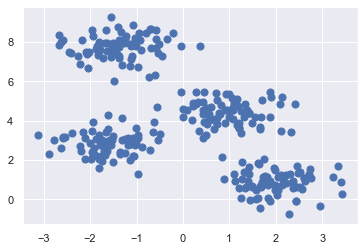

In [2]:
# generate 4 clusters for testing
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [3]:
# fit data points to the kMean function and predict the cluster each belongs 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)    # need to assign the no. of clusters one suppose to have
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
y_kmeans[:10]    # cluster of first 10 points

array([0, 2, 1, 2, 0, 0, 3, 1, 2, 2])

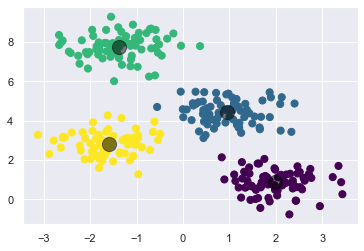

In [4]:
# plot the cluster by color and their centres
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

# The Algorithm (Lloyd’s algorithm) 
1. The algorithm first guess $k$ cluster centers from data points.
2. Then it assigns each data point to the nearest cluster center, and calculate the mean of all points in a cluster as the new cluster center.
3. The above step is <b>repeated over and over until convergence</b>, i.e. all cluster centers do not change any further.

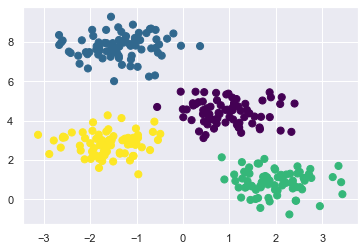

In [5]:
# write the k-means algorithm from sketch
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    
    # permute the number of rows of data and assign the first n as clusters
    i = rng.permutation(X.shape[0])[:n_clusters]   
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        # return index of centres that is the closest to each point in X
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])    # mean(0) takes mean down the row
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

# Challenges with K-Means

## Result depends on initial center values

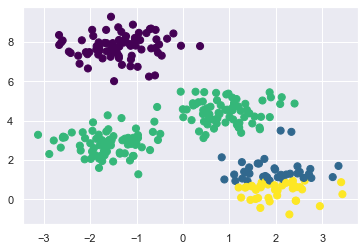

In [6]:
# use a different random seed attain a different result
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

- One can see that this result is worse compared with the previous one, we say that a global optimal is not attained in this case. 
- To avoid this from happening, sklearn kMeans() has parameters <b>init</b> and <b>n_init</b> to determine <b>the way to initialize cluster centers</b> and <b>the number of time the k-mean alogrithm will run on different seeds</b>.
- The default value of <b>init</b> is <b>k-means++</b>, which picks the best k-Means result from several running with different random seeds by choosing one with <b>minimum inertia</b>.
- The inertia of a set of $N$ samples grouped into $K$ disjoint clusters $C$ with cluster mean $\mu_1, \mu_2,..., \mu_K$ is defined as <br><br> $$\sum_{i=0}^{N}\text{min}_{\mu_j \in C}(\|x_i-\mu_j\|^2)$$ <br>which is equivalent to <b>the sum of distances between each point and their cluster center</b>.

## The number of clusters need be determined beforehand
- The algorithm cannot learn the number of clusters from the data.
- <b>Silhouette analysis</b>, which indicates how far each sample point in a cluster is from neighboring cluster (the next best cluster for the point), can be used to tell in certain extent which number of cluster is better.
- The <b>Silhouette coefficient</b> of a point, which measures the relative ratio of mean distance from points in assigned cluster and mean distance from points in the second best cluster, has a range of [-1, 1].
- The <b>larger</b> the coefficient, the <b>better</b> the assignment of that point to the 'right' cluster. 
- Details of mathematical definition at: https://en.wikipedia.org/wiki/Silhouette_(clustering)<br>
  Details of implementation at: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

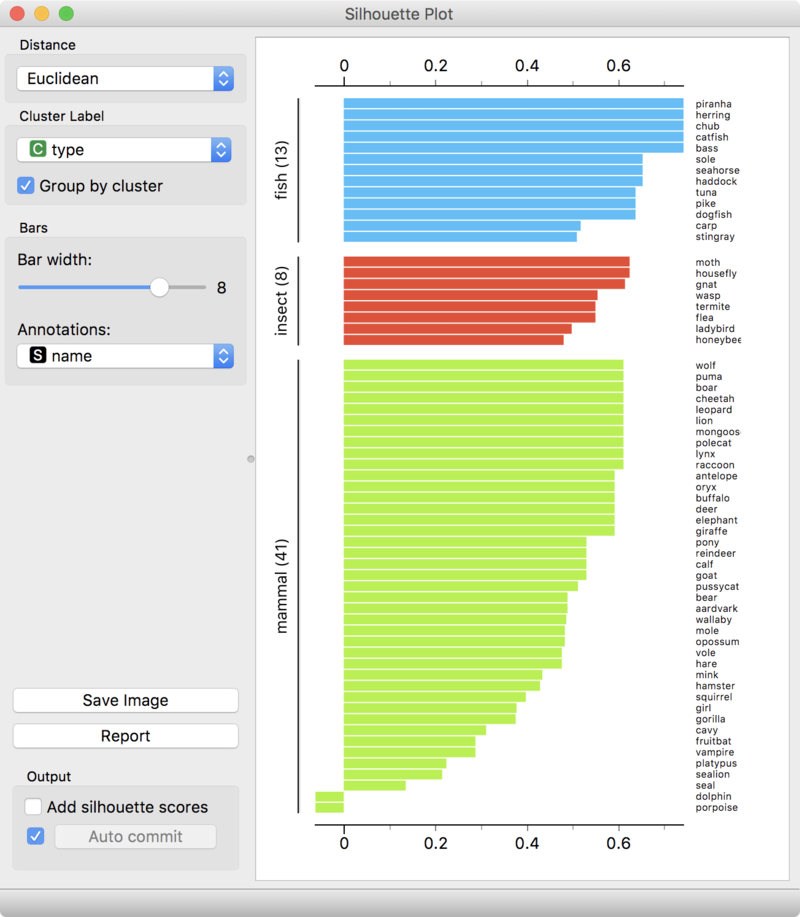

In [7]:
display.Image('img/4_silhouette_analysis.png', width=700)

In [8]:
# how result varies with value of k
from ipywidgets import interact, fixed
def plot_kmeans(X, k):
    labels = KMeans(k, random_state=0).fit_predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');
interact(plot_kmeans, k=(2, 6), X=fixed(X));

interactive(children=(IntSlider(value=4, description='k', max=6, min=2), Output()), _dom_classes=('widget-inte…

There are other more complicated clustering algorithms that can choose the suitable number of clusters by itself, such as <b>DBSCAN, mean-shift, affinity propagation</b>, etc.

## K-means is not suitable for high dimensional data

### Failing of Euclidean Distance in High Dimensional Space
- High dimension usually means <b>at least hundreds of dimensions</b> for a <b>dense vector</b> (most of the values are non-zero, one could calculate the <b>sparsity</b> of a given vector/matrix to determine).
- K-means optimizes the variance of data points, which is actually calculating Euclidean distances.
- Euclildean distance actually fails to provide a good discrimination between points in high dimensional spaces, which is one problem of <b>the curse of dimensionality</b>.

In [9]:
# A glimpse of how distance metrics become much less meaningful in high dimension
# how mean pairwise distance and the difference between farest and nearest points change with dimension
from sklearn.metrics import pairwise_distances
from ipywidgets import interact, fixed
rng = np.random.RandomState(42)
def mean_distance(d, metric):
    X = rng.rand(1000, d)
    pairwise_d = pairwise_distances(X)    # return a euclidean distance matrix d(i,j) = distance between ith and jth point
    origin_d = pairwise_distances(X, np.zeros((1, d)), metric=metric)
    relative_contrast = (origin_d.max()-origin_d.min())/origin_d.min()
    print(f'max pairwise distance = {np.max(pairwise_d):.2f}')
    print(f'nearest distance from the origin = {origin_d.min():.2f}')
    print(f'relative contrast = {relative_contrast:.2f}')
interact(mean_distance, d=(1, 1000), metric=['l1', 'l2']);
# l1 norm performs a bit better than l2 norm in high dim but problem still exist in general

interactive(children=(IntSlider(value=500, description='d', max=1000, min=1), Dropdown(description='metric', o…

- When dimension increases, the increase in the pairwise distance is much slower than the increase in length of vectors, which means <b>the points become less distinguishable</b> using distance metrics as comparison.
- Therefore when dimension is high, <b>dimension reduction like PCA</b> should be performed before using k-means clustering.

### Curse of dimensionality
- It generally refers to the phenomena that arises when analyzing high dimensional spaces that <b>do not occur in low dimensional spaces</b>.
- In ML, the <b>average predictive power of a classifier/regressor</b> first increases with the number of features but beyond certain dimensionality it starts to deteriorating.
- Researches show that high dimensions itself does not necessarily affects prediction, but the ratio of relevant to irrelavant dimensions (<b>signal-to-noise ratio</b>) should be high for accurate modelling.

# Non-linear Cluster Boundaries
- Two assumptions of k-means:
    1. Points of a cluster are <b>spherical</b> around the cluster center.
    2. Any point should be closer to its own cluster center than other centers.
- The above assumptions may not be true for more complicated geometries (mathematically <b>non-convex space</b>) of which the distance between center and data points is not a good description of that cluster, like a moon shape or a smiley face.

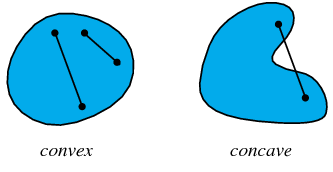

In [10]:
# a convex space contains all line segments joining any two points in the space
display.Image('img/4_convex.png')

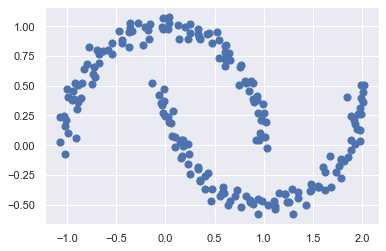

In [11]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

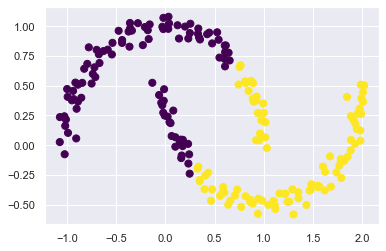

In [12]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

Luckily, similar to non-linear boundary problems in SVM, one could use the kernalized version of k-means which projects data to higher dimensional space where a linear separation is possible. This method is called <b>spectral clustering</b> which transform data to a lower dimensional space.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


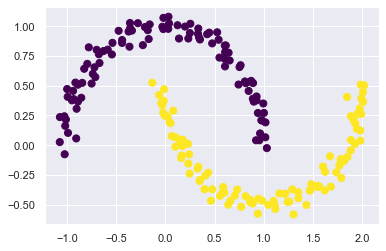

In [13]:
from sklearn.cluster import SpectralClustering
# the affinity/similarity/weight matrix measurse similarity between points
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', n_neighbors=10, assign_labels='kmeans')
# affinity matrix A has value a
# take the average of A and A.T, has values 0, 1/2, 1
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

## Algorithm of Spectral Clustering (Optional)
- The main idea is to <b>find a graph representation of the data</b> followed by <b>partitioning the graph into $k$ highly inter-connected and lowly intra-connected clusters</b>.
- The steps of spectral clustering of $k$ clusters in sklearn are as follow:
<ol>
    <li>Create a similarity graph $G=(V,E)$ of $N$ data points, edges are defined by a specific way (in this example we use kNN with k=10, which means for a point X, the edges between X and its 10 nearest points are assigned as 1, and the edges between X and any other points are assigned as 0.</li>
    <li>From the above graph, generate an <b>affinity matrix</b> $A$, where <br><br>$$A_{ij} = \text{weight of the edge joining } X_i \text{and} X_j$$.</li><br>
    <li>Since $A$ above is asymmetric (because of the nature of kNN), to get a symmetric matrix which ensure eigenvectors exist (a $n\times n$ symmetric matrix has the nice property that it mush have $n$ orthogonal eigenvectors), we define a new <b>affinity matrix</b> $A'$, where <br><br>$$A' = \frac{1}{2}(A+A^{t})$$<br> so that $A_{ij}$ can have values 0, $\frac{1}{2}$, 1. $\frac{1}{2}$ means one vertex is one of the nearest points of the other but not vice versa.<br></li>
    <li>The <b>degree matrix</b> $D$ is a diagonal matrix defined by<br><br>$$D_{ii} = \text{no. of nodes } X_i \text{ connected to}=\sum_{j}{A_{ij}'}$$<br></li>
    <li>Now calculate the <b>Laplacian matrix</b> $L = D-A'$, equivalently, <br><br>$$L_{ij} = 
    \begin{cases}
      D_{ii} & \text{if $i=j$}\\
      -A'_{ij} & (i,j)\in E\\
      0 & (i,j)\notin E
    \end{cases} $$<br></li>
    <li>Computer the first $k$ eignvectors with the smallest eigenvalues (greater than 0) $u_1, u_2,..., u_k$, forming a matrix $U = [u_1 u_2 ... u_k]$ of shape $N \times k$.</li>
    <li>Regard $i$-th row of $U$ as the original data point $X_i$, use k-means alogrithm to cluster them.</li>
</ol>

# Use Cases

## Clustering Digits without Labels

In [14]:
# load handwriting digits dataset
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [15]:
# clustering the 1797 digits
kmeans = KMeans(n_clusters=10, random_state=3)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

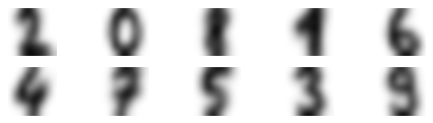

In [16]:
# visualize all cluster centers
fig, ax = plt.subplots(2, 5, figsize=(8, 2))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='bicubic', cmap=plt.cm.binary)   # use bicubic interpolation to sharpen images

In [17]:
# match cluster result back to original label 
from scipy.stats import mode
# initialise a zero array for storing final labels
labels = np.zeros_like(clusters)
for i in range(10):
    # for each new label, match back to the old labels by finding mode of old labels in the same positions
    mask = (clusters == i)   # a boolean mask vector
    labels[mask] = mode(digits.target[mask])[0]

In [18]:
# overall acc is a fair measure if data is balanced
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7896494156928213

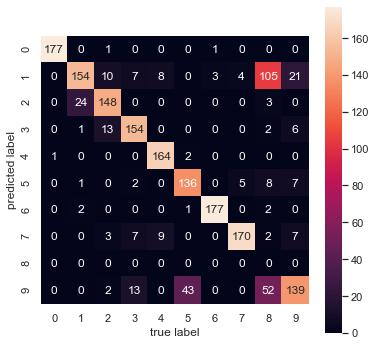

In [19]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
plt.figure(figsize=(6, 6))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Except many 8 are misinterpreted as in the same cluster as 1 or 9, the overall result is not bad even without labels, it verifies that k-means can actually help us to 'classify' data in case we do not have any labels.

## Color Compression/Image Quantification
- A type of lossy/irreversible image compression by reducing color space to the most common colors.
- Reduce cost for storage, transmission and further modelling like classification task

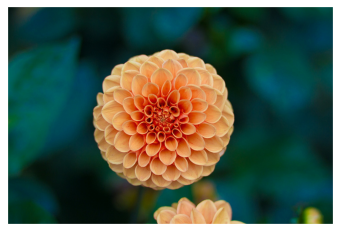

In [20]:
from sklearn.datasets import load_sample_image
flower = load_sample_image("flower.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(flower);

In [21]:
flower.shape

(427, 640, 3)

In [22]:
data = flower / 255.0    # convert from 0-255 to 0-1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

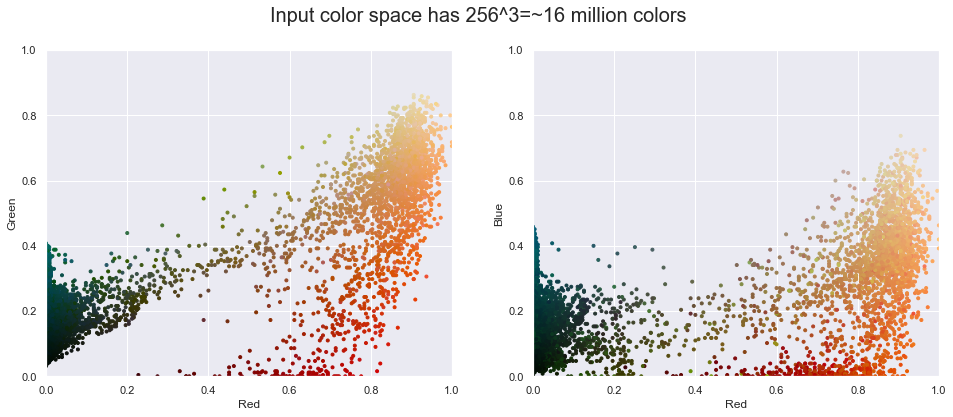

In [23]:
# plot 2d graph of color pixel by RGB values
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T    # get coordinates
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

plot_pixels(data, title='Input color space has 256^3=~16 million colors')

- Since the number of pixels for each image is large, here we use <b>mini batch k-means</b> instead, which use subsets (batch) of input data in each iteration to compute new centroids. It makes <b>computation time shorter at the expense of a bit accuracy</b>.
- One can see a comparison of the two algorithms at:<br> https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html#sphx-glr-auto-examples-cluster-plot-mini-batch-kmeans-py

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


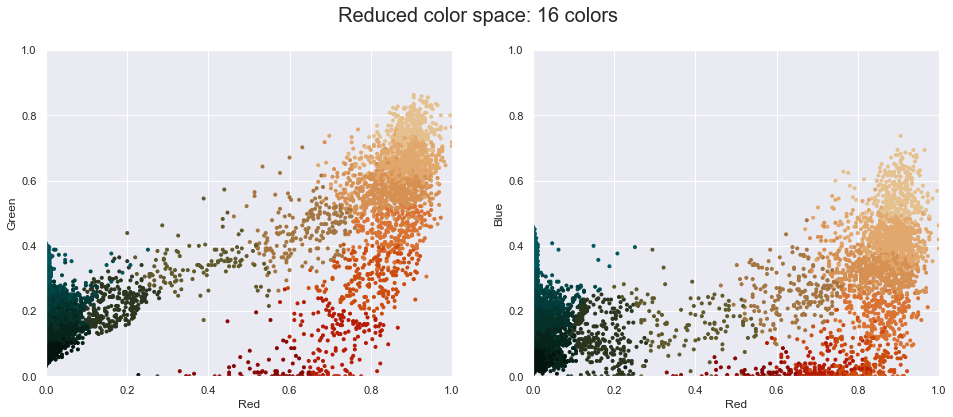

In [24]:
# group the colors to 16 cluster and use the cluster centre to represent them instead
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
# get the new color representation of each pixel by cluster class prediction (fancy indexing)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]
plot_pixels(data, colors=new_colors, title="Reduced color space: 16 colors")

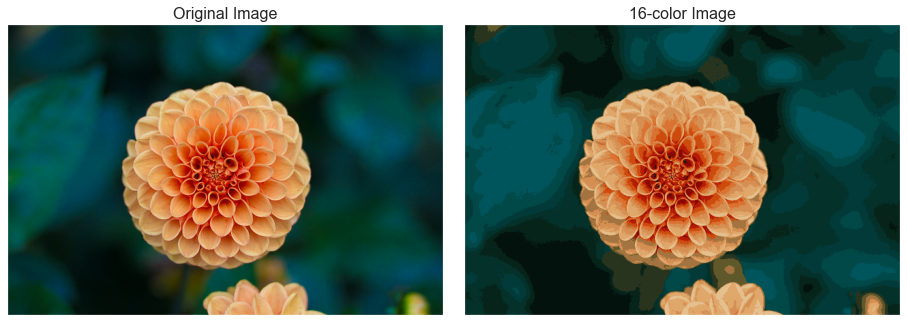

In [25]:
# new image is still recognizable
flower_recolored = new_colors.reshape(flower.shape)
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(flower)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(flower_recolored)
ax[1].set_title('16-color Image', size=16);